# A quickstart guide

This guide shall run you through how to get your own trading strategy up and running, and backtested against some mocked data.

A trading node, in its current WIP state, consists of three key components:
1. `DataClient`: data provider, e.g. minute price data of a stock like AAPL
2. `Portfolio`: maintains state of trading portfolio
3. `Strategy`: the "engine" of the system which contains all business logic

## 1. Data Client

Every trading strategy requires data to base its decisions off. We use a publisher/subscriber architecture here. Essentially, the `DataClient` publishes data, and the `Strategy` instance subscribes to it. This is done via streaming data from the `DataClient` to `Strategy`.

Those who have taken CS2030S would recognise similarities between the event-driven system and the early labs, as well as the pub/sub system to Java `streams`.

To begin, we initialise an `aapl_data_client` which *publishes* a stream of minute data. Note that since we have not yet initialised a `Strategy` class, the data client has no subscribers.

In [1]:
from orbital.data.client import MockBarTickDataClient

aapl_data_client = MockBarTickDataClient(
    data_file_path='./orbital/data/mocked/AAPL.parquet',
    file_type='parquet',
    # max_ticks=100000,
    symbol='aapl'
    )

Data Client has 2268618 ticks


We can view the first data point of the stream by calling the *private* function `_fetch_data`.

In [2]:
dp = aapl_data_client._fetch_data()
vars(dp)

{'timestamp': '2007-04-27T10:43:00',
 'class_name': 'BarTick',
 'symbol': 'aapl',
 'open': 98.41000366210938,
 'high': 98.45999908447266,
 'low': 98.30000305175781,
 'close': 98.30000305175781,
 'volume': 46196}

## 2. Portfolio

The `Portfolio` component tracks the current state of the portfolio. Here, we initialise it with starting cash and positions.

In [3]:
from orbital.portfolio.base import Portfolio

demo_portfolio = Portfolio(
    cash=1_000_000, # starting free cash
    positions=[] # start with empty positions
)

## 3. Strategy

The `Strategy` component serves as the "engine" to integrate with the data and portfolio components to process data to generate orders.

To begin, we've created a basic `DemoStrategy` which extends from the `BaseStrategy` class. At the moment, any custom `Strategy` must implement only the `handle_data` method.

The logic of the `DemoStrategy` is simple, for any instrument:
- if not in the portfolio, buy 100 shares of it
- if the market price is less than 90% of its price in the portfolio, buy
- if the market price is more than 110% of its price in the portfolio, sell

In [4]:
from orbital.strategy.demo import DemoStrategy

demo_strategy = DemoStrategy(portfolio=demo_portfolio)

## 4. BacktestNode

The `BacktestNode` component serves as the wrapper around all components to handle message logic.

In [5]:
from orbital.node.BacktestNode import BacktestNode

backtest_node = BacktestNode(strategy=demo_strategy, data_clients = [aapl_data_client])

We now begin run the `backtest_node`. This begins the simulation.

In [6]:
backtest_node.run()

Data client <orbital.data.client.MockBarTickDataClient object at 0x7fafe8ca33d0> completed publishing
All data clients completed publishing


Now that our simulation has ended, let's view some statistics.

In [7]:
demo_portfolio.to_dataframe() # end state of portfolio

,Symbol,Quantity,Entry Price,Created Time,Updated Time
0,aapl,100,137.940002,2023-07-31 03:54:56.763568,2023-07-31 03:54:58.280840


In [8]:
demo_portfolio.statistics()

{'total_value': 1995500.961303711,
 'position_values': 12769.999694824219,
 'free_cash': 1982730.9616088867,
 'realised_profit': 996524.9618530273,
 'unrealised_profit': -1024.0005493164062}

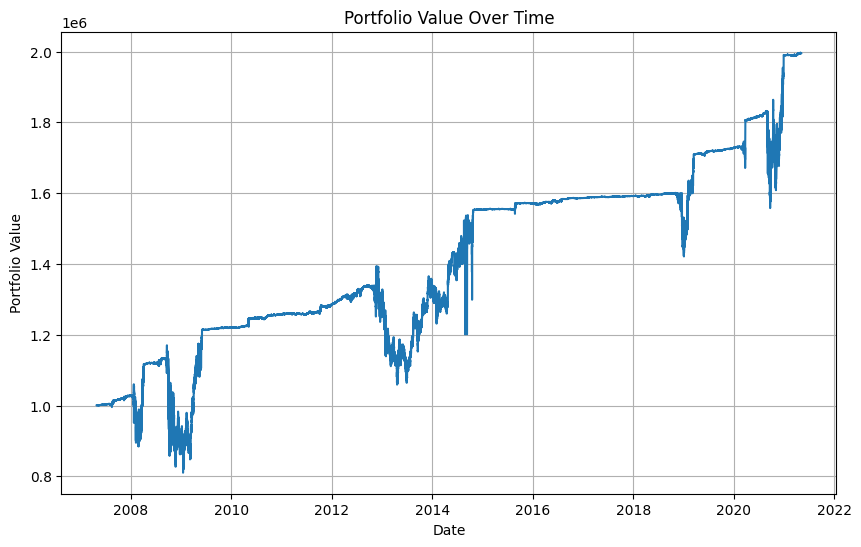

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = [{
    'value': state.value,
    'created_time': state.created_time
    } for state in demo_portfolio.history]

df = pd.DataFrame(data)

# Convert 'created_time' to datetime format if it isn't already
df['created_time'] = pd.to_datetime(df['created_time'])

plt.figure(figsize=(10, 6))  # This creates a new figure, and sets the size of the figure
sns.lineplot(data=df, x='created_time', y='value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

We are done!